# Data Source:  https://covid19.ssp.df.gov.br/extensions/covid19/covid19.html#/

# Part 1 - Extracting and transforming data

# 1. Importing data

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('dados-abertos.csv', sep = ';')
df = pd.DataFrame(df)

In [2]:
df = df[df['Óbito'] == 'Sim'].reset_index(drop=True)

# 2. Deletes unused columns

In [3]:
colunas = ['Data','Sexo','Faixa Etária','UF','Óbito','dataPrimeirosintomas','Pneumopatia','Nefropatia','Doença Hematológica','Distúrbios Metabólicos','Imunopressão','Obesidade','Outros','Cardiovasculopatia']
df.drop(columns = colunas,inplace=True)

# 3. Converts column 'data' to datetime, fill empty dates with next non-blank value and creates a column with 1 to each case observed (will be used as value)

In [4]:
df['data'] = pd.to_datetime(df['Data Cadastro'], dayfirst = True)
df.drop(columns = 'Data Cadastro', inplace=True)
df.fillna(method='ffill', inplace = True)
df['qtd'] = 1
df['datastring'] = df['data'].dt.strftime('%Y-%m-%d')
df['dataRA'] = df['datastring'] + df['RA']
df.drop(columns = 'datastring', inplace = True)
data_max = max(df['data'])
data_max = data_max.to_pydatetime().date()

# 4. Creates a list with all dates between today and the day of the first case in Federal Distict (16/3/2020)

In [5]:
# Cria uma lista com todas as datas entre hoje e o dia do primeiro caso no DF (16/3/2020)

from datetime import date, timedelta, datetime

def rangedata(data1, data2):
    for n in range(int((data2 - data1).days)+1):
        yield data1 + timedelta(n)
        
lista_datas = []
data_fim = data_max
data_ini = date(2020,3,16)
for dt in rangedata(data_ini, data_fim):
    lista_datas.append(dt.strftime("%Y-%m-%d"))

# 5. Creates a list with all cities of Federal District data and removes the unwanted (not informed and blanks)

In [6]:
cidades = []
for x in df.RA.unique():
    cidades.append(x)
cidades = cidades[:-2]

# 6. Creates an auxiliar DataFrame with all combinations of date and city

In [7]:
from itertools import product
df_aux = pd.DataFrame(list(product(lista_datas,cidades)))
df_aux.columns = ['data','RA']
df_aux['dataRA'] = df_aux['data'] + df_aux['RA']

# 7. Reorder columns of the auxiliar DF preparing for a merge and groups the original DF by date and city

In [8]:
df_aux = df_aux[['dataRA','data','RA']]
df = df[['dataRA','data','RA','qtd']]
df.groupby('dataRA').agg('sum')

,qtd
dataRA,
2020-03-28Guará,1
2020-03-29Jardim Botânico,2
2020-03-29Plano Piloto,1
2020-03-29Sudoeste/Octogonal,1
2020-03-31Gama,1
...,...
2021-01-29Planaltina,1
2021-01-30Santa Maria,1
2021-01-30Taguatinga,1


# 8. Creates the final DF, joining the two previous created DFs to obtain rows with the number of cases and cummulative cases per day for each city

In [9]:
df_final = pd.merge(df_aux,df,on='dataRA',how='left')
df_final.drop(columns=['dataRA','data_y','RA_y'], inplace=True)
df_final.columns = ['data','ra','casos']
df_final.groupby(['ra','data'], as_index = False).agg('sum')
df_final = df_final.groupby(['ra','data'], as_index = False, dropna = False).agg('sum').sort_values(by=['ra','data'], ascending=True).reset_index(drop=True)
df_final = df_final[['ra','data','casos']]
df_final['casosacum'] = df_final.groupby('ra')['casos'].cumsum()

# 9. Removes the cities that are not actually cities (Other states and metropolitan area of Federal District)

In [10]:
indices_fora = df_final[(df_final['ra'] == 'Outros Estados') | (df_final['ra'] == 'Entorno DF') ].index
df_final.drop(indices_fora, inplace = True)
df_final.reset_index(drop=True)

,ra,data,casos,casosacum
0,Brazlândia,2020-03-16,0.0,0.0
1,Brazlândia,2020-03-17,0.0,0.0
2,Brazlândia,2020-03-18,0.0,0.0
3,Brazlândia,2020-03-19,0.0,0.0
4,Brazlândia,2020-03-20,0.0,0.0
...,...,...,...,...
9946,Águas Claras,2021-01-26,0.0,112.0
9947,Águas Claras,2021-01-27,0.0,112.0
9948,Águas Claras,2021-01-28,0.0,112.0
9949,Águas Claras,2021-01-29,0.0,112.0


In [11]:
#IMPORTAR A LISTA DE POPULAÇÕES POR RA, REMOVER AS DUAS RAS QUE NÃO TEM POPULAÇÃO AINDA (ARNIQUEIRAS E POR DO SOL)
#DEPPOIS FAZER A CONTA PRA TER O NUMERO DE CASOS POR HABITANTE E O ACUMULADO -> NCASOS POR 1000HAB = (CASOS *1000)/POP

pop = pd.read_excel('populaçõesra.xlsx')
df_pop = pd.merge(df_final, pop, on='ra')
df_pop['popacum'] = (df_pop['casosacum'] * 100000)/df_pop['pop']

# 10. Saves the file on a excel sheet that will be used as source for creating the Bar Chart Race

In [12]:
df_pop.to_excel('covid_bsb_completo_pop.xlsx')

# Part 2 - Creating the Bar Chart Race

# 11. Importing the required libraries

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML


Bad key "text.kerning_factor" on line 4 in
C:\Users\bcpython\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# 12. Importing the source sheet

In [14]:
base = pd.read_excel('covid_bsb_completo_pop.xlsx', index_col = 0)
base.head()

,ra,data,casos,casosacum,pop,popacum
0,Brazlândia,2020-03-16,0,0,63414,0.0
1,Brazlândia,2020-03-17,0,0,63414,0.0
2,Brazlândia,2020-03-18,0,0,63414,0.0
3,Brazlândia,2020-03-19,0,0,63414,0.0
4,Brazlândia,2020-03-20,0,0,63414,0.0


# 13. Removes the cases columns (we are only using the cummulative cases)

In [15]:
base.drop(columns = ['casos','casosacum'], inplace = True)
base

,ra,data,pop,popacum
0,Brazlândia,2020-03-16,63414,0.000000
1,Brazlândia,2020-03-17,63414,0.000000
2,Brazlândia,2020-03-18,63414,0.000000
3,Brazlândia,2020-03-19,63414,0.000000
4,Brazlândia,2020-03-20,63414,0.000000
...,...,...,...,...
9625,Águas Claras,2021-01-26,161278,69.445306
9626,Águas Claras,2021-01-27,161278,69.445306
9627,Águas Claras,2021-01-28,161278,69.445306
9628,Águas Claras,2021-01-29,161278,69.445306


# 14. Creating the sequence of days that will be used as index to the BarChartRace

In [16]:
df_seq = base.drop(columns = ['ra','popacum'])
df_seq = df_seq.groupby('data').agg('max').reset_index()
df_seq['seq']= df_seq.index
df_seq

,data,pop,seq
0,2020-03-16,437309,0
1,2020-03-17,437309,1
2,2020-03-18,437309,2
3,2020-03-19,437309,3
4,2020-03-20,437309,4
...,...,...,...
316,2021-01-26,437309,316
317,2021-01-27,437309,317
318,2021-01-28,437309,318
319,2021-01-29,437309,319


# 15. Creating a DataFrame with regions and cities of the Federal District

In [17]:
dic_regioes = {'Central': ['Plano Piloto','Lago Sul','Lago Norte',  
          'Sudoeste/Octogonal','Cruzeiro','Candangolândia',
          'Park Way','Varjão','Guará','Núcleo Bandeirante',
          'Riacho Fundo','Águas Claras','Vicente Pires',
          'SIA','SCIA'],
           'Oeste':['Taguatinga','Samambaia','Ceilândia','Brazlândia',
         'Arniqueira','Pôr do Sol'],
           'Sul':['Gama','Santa Maria','Riacho Fundo II','Recanto das Emas'],
           'Leste':['Paranoá','Itapoã','São Sebastião','Jardim Botânico'
         ,'Sistema Penitenciário'],
           'Norte':['Sobradinho','Sobradinho II','Planaltina','Fercal']  
}

df_regioes = pd.DataFrame([(k,v) for (k, L) in dic_regioes.items() for v in L],
                       columns = ['regiao','ra'])

df_regioes.head()

,regiao,ra
0,Central,Plano Piloto
1,Central,Lago Sul
2,Central,Lago Norte
3,Central,Sudoeste/Octogonal
4,Central,Cruzeiro


# 16. Joining the region and sequence columns to the DataFrame

In [18]:
base = base.merge(df_seq, left_on = 'data', right_on ='data')
base = base.merge(df_regioes, left_on = 'ra', right_on ='ra')
base

,ra,data,pop_x,popacum,pop_y,seq,regiao
0,Brazlândia,2020-03-16,63414,0.000000,437309,0,Oeste
1,Brazlândia,2020-03-17,63414,0.000000,437309,1,Oeste
2,Brazlândia,2020-03-18,63414,0.000000,437309,2,Oeste
3,Brazlândia,2020-03-19,63414,0.000000,437309,3,Oeste
4,Brazlândia,2020-03-20,63414,0.000000,437309,4,Oeste
...,...,...,...,...,...,...,...
9625,Águas Claras,2021-01-26,161278,69.445306,437309,316,Central
9626,Águas Claras,2021-01-27,161278,69.445306,437309,317,Central
9627,Águas Claras,2021-01-28,161278,69.445306,437309,318,Central
9628,Águas Claras,2021-01-29,161278,69.445306,437309,319,Central


# 17. Creates a variable with the amount of days in the sequence (will be used on the BCR)

In [19]:
qtd_dias = base['seq'].max()
qtd_dias

320

# 18. Defines a dictionary with colors for each region (will be used on the BCR)

In [20]:
cores = dict(zip(
    ["Central", "Oeste", "Sul", "Leste", "Norte"],
    ["#adb0ff", "#ffb3ff", "#90d595", "#e48381", "#f7bb5f"]))

# 19. Defines a dictionary with each city and its respective region (will be used on the BCR)

In [21]:
ra_procv = base.set_index('ra')['regiao'].to_dict()
ra_procv

{'Brazlândia': 'Oeste',
 'Candangolândia': 'Central',
 'Ceilândia': 'Oeste',
 'Fercal': 'Norte',
 'Gama': 'Sul',
 'Guará': 'Central',
 'Itapoã': 'Leste',
 'Jardim Botânico': 'Leste',
 'Lago Norte': 'Central',
 'Lago Sul': 'Central',
 'Núcleo Bandeirante': 'Central',
 'Paranoá': 'Leste',
 'Park Way': 'Central',
 'Planaltina': 'Norte',
 'Plano Piloto': 'Central',
 'Recanto das Emas': 'Sul',
 'Riacho Fundo': 'Central',
 'Riacho Fundo II': 'Sul',
 'SCIA': 'Central',
 'Samambaia': 'Oeste',
 'Santa Maria': 'Sul',
 'Sistema Penitenciário': 'Leste',
 'Sobradinho': 'Norte',
 'Sobradinho II': 'Norte',
 'Sudoeste/Octogonal': 'Central',
 'São Sebastião': 'Leste',
 'Taguatinga': 'Oeste',
 'Varjão': 'Central',
 'Vicente Pires': 'Central',
 'Águas Claras': 'Central'}

# 20. Plots the Bar Chart Race

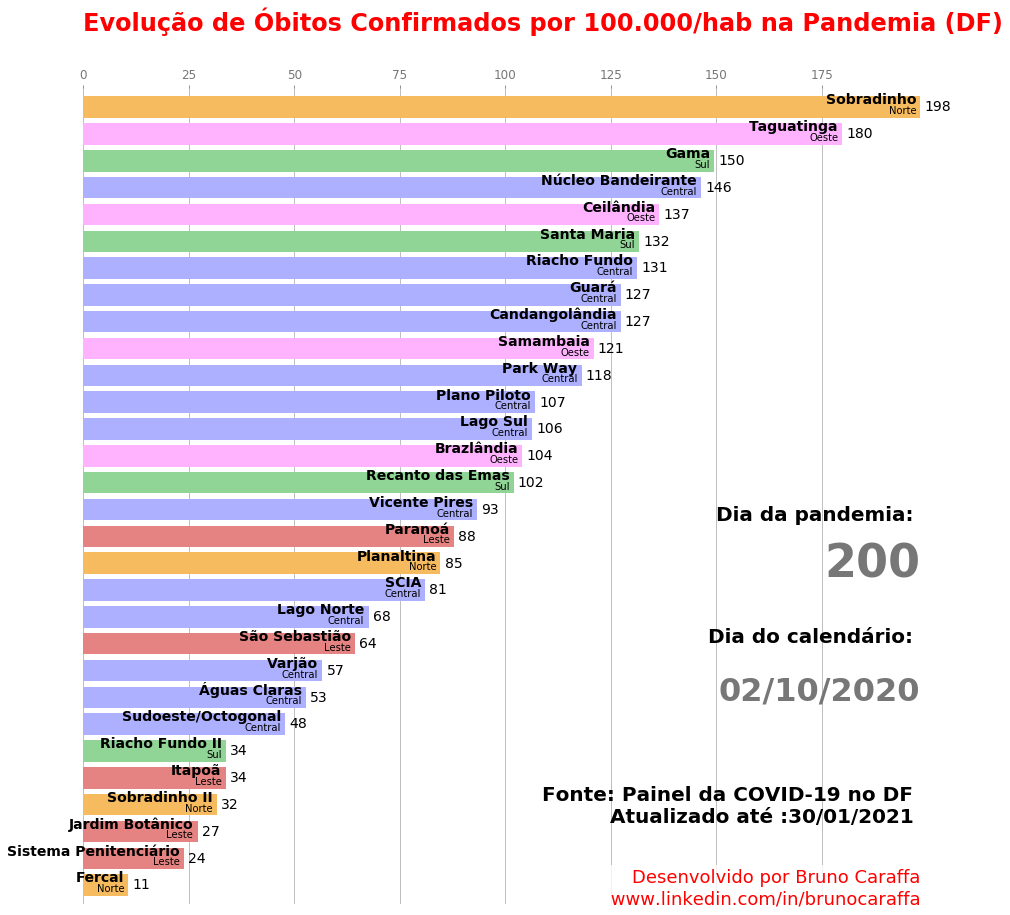

In [22]:
fig, ax = plt.subplots(figsize=(15, 15))

def draw_barchart(current_seq):
    dff = base[base['seq'].eq(current_seq)].sort_values(by=['popacum','ra'], ascending=[True,False])#.tail(10)
    dff.head(10)
    ax.clear()
    ax.barh(dff['ra'], dff['popacum'], color=[cores[ra_procv[x]] for x in dff['ra']])
    dx = dff['popacum'].max() / 200
    dfdata = df_seq[df_seq['seq'].eq(current_seq)].sort_values(by=['data'], ascending=[True])
    dfdata['data'] = pd.to_datetime(dfdata['data'])

    for i, (value, name) in enumerate(zip(dff['popacum'], dff['ra'])):
        ax.text(value-dx, i,     name,           size=14, weight=600, ha='right', va='bottom')
        ax.text(value-dx, i-.25, ra_procv[name], size=10, ha='right', va='baseline')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')                  
    ax.text(1, 0.47, 'Dia da pandemia: ', transform=ax.transAxes, size=20, ha='right', weight=800)    
    ax.text(1, 0.4, current_seq, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(1, 0.32, 'Dia do calendário: ', transform=ax.transAxes, size=20, ha='right', weight=800) 
    for i, (data, seq) in enumerate(zip(dfdata['data'], dfdata['seq'])):
        ax.text(1, 0.25, f'{data:%d/%m/%Y}', transform=ax.transAxes, color='#777777', size=32, ha='right', weight=800)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.1, 'Evolução de Óbitos Confirmados por 100.000/hab na Pandemia (DF)',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top', color='#FF0000' )
    ax.text(1, 0, 'Desenvolvido por Bruno Caraffa\n www.linkedin.com/in/brunocaraffa', 
            transform=ax.transAxes, color='#FF0000', ha='right',
            size=18, bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    ax.text(1, 0.1, f'Fonte: Painel da COVID-19 no DF \n Atualizado até {data_max::%d/%m/%Y} ', transform=ax.transAxes, size=20, ha='right', weight=800)
    plt.box(False)
    
draw_barchart(200)

# 21. Saves all the frames of the BarChartRace function as GIF on the directory

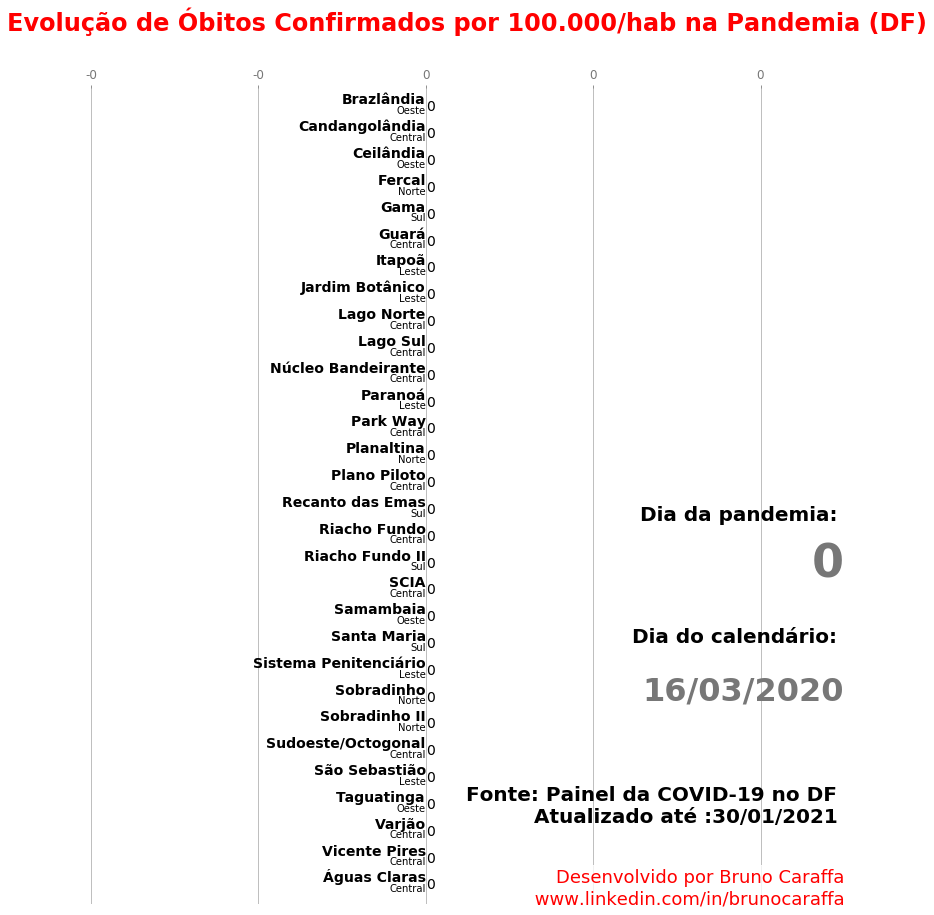

In [23]:
fig, ax = plt.subplots(figsize = (15,15))
animator = animation.FuncAnimation(fig, draw_barchart, frames = range(0,qtd_dias), interval = 400)
plt.rcParams['animation.embed_limit'] = 2**128
HTML(animator.to_jshtml())
f = r"covidbsbFINALpopobitos.gif" 
writergif = animation.PillowWriter(fps=3.2) 
animator.save(f, writer=writergif)